# Quantum Spectral Graph Analysis - Whitepaper #1

# Efficient Quantum Representation of Exponentially Large Laplacian Matrices

Ohad Lev

August-September 2025

-------

## (0) Imports

In [1]:
import warnings

import networkx as nx
from IPython.display import Math

import numpy as np
from numpy.typing import NDArray

from qiskit.quantum_info import SparsePauliOp
from qiskit.visualization import array_to_latex

from qsga.hamiltonian_generators import obtain_skeleton_laplacian
from qsga.graphics import sparse_pauli_op_to_latex, obtain_math_text_hermitian_spectrum
from qsga.data_verifiers import is_valid_laplacian
from qsga.util import decompose_laplacian_matrix

warnings.filterwarnings("ignore", category=np.ComplexWarning)

----------------

## (1) Hermitian Matrices and Pauli Basis

It is well known that the set of $n$-length Pauli (+ identity) operators, which I denote $\mathcal{P_{n}}$, forms a basis for the space of all $2^n \times 2^n$ Hermitian matrices, when summed with real coefficients. When summed with possibly complex coefficients, the set forms a basis for all $2^n \times 2^n$ matrices over the complex numbers. We will focus on the case of real coefficients and Hermitian matrices.

As toy examples one can consider the case of $n = 1$, where the space of all $2 \times 2$ Hermitian matrices $\mathbb{H}_2$ is:

$$
    \mathbb{H}_2 = \mathrm{span}_{\mathbb{R}} \big(\mathcal{P}_1\big) = \mathrm{span}_{\mathbb{R}} \big\{I, X, Y, Z \big\}
    \tag{1}
$$

And the case where $n = 2$:

$$
    \mathbb{H}_4 = \mathrm{span}_{\mathbb{R}} \big(\mathcal{P}_2\big) =
    \mathrm{span}_{\mathbb{R}} \big\{
        II, IX, IY, IZ, XI, XX, XY, XZ, YI, YX, YY, YZ, ZI, ZX, ZY, ZZ \big
    \}
    \tag{2}
$$

It is easily seen that the dimension of the Pauli basis grows exponentially with $n$:

$$
    \big|\mathcal{P}_{n}\big| = 4^n
    \tag{3}
$$

So the general case of creating an $n$-exponentially large Hermitian matrix from the Pauli basis seems exponentially hard. However, any real combination of $n$-length Pauli strings yields a valid $2^n \times 2^n$ Hermitian operator, and this fact is very helpful, and of great use in many quantum computing domain applications.

--------

## (2) Graph Laplacians

Consider a simple, undirected, unweighted, possibly disconnected graph $\mathbf{G}$, with $|\mathcal{V}|$ nodes and $|\mathcal{E}|$ edges:

$$
    \mathbf{G} = (\mathcal{V}, \mathcal{E})
    \tag{4}
$$

Then its Laplacian matrix is:

$$
    L(\mathbf{G}) = D(\mathbf{G}) - A(\mathbf{G})
    \tag{5}
$$

Where:

* $D(\mathbf{G})$ is the degree diagonal matrix of a graph $\mathbf{G}$, with the degree of each of its $∣\mathcal{V}∣$ nodes on the diagonal.
* $A(\mathbf{G})$ is the adjacency matrix of the graph.

The Laplacian matrix:

* Is symmetric and real, hence also Hermitian.
* Has interesting properties, eigenspectrum and eigendecomposition. E.g. the second smallest eigenvalue of the Laplacian $\lambda_2$ is called the *algebraic connectivity* of the graph, and it "tells" us something about the underlying connectivity of the graph. $\lambda_2 \geq 0$, and the case of $\lambda_2 = 0$ occurs if and only if the graph is disconnected.

-------

## (3) Domains Intersection

The intersection of the topics briefly discussed in sections **(1)** and **(2)** has sparked several ideas and research directions in my mind, due to the following facts:

* It is guarenteed that any graph can be represented "quantumly" (but not necessarily efficiently) by decomposing its Laplacian matrix to Pauli basis elements, as explained in sections **(1)** and **(2)**.

* For exponentially large graphs, it seems that we have no efficient classical way to learn their spectral properties, or any of their global properties at all (it might not be a strict fact for all graphs, and we should verify that later on).

* In the domain of quantum algorithms, there exist already several techniques and tools to learn spectral properties of Hermitian matrices: VQE (NISQ, variational), KQD + SQD (NISQ-mid term, non-variational), Phase Estimation (fault-tolerance required), and more.

That leads me to the initial research question:

----------

## (4) (Initial) Research Question

<div class="alert alert-block alert-info">
<center><b>Can we come up with an efficient method to "quantumly" represent certain families of exponentially large graphs?</b></center>
</div>

----------

## (5) A Regular, Structured Case

We begin from the beginning, and try to tackle the research question for the more simple case of regular graphs. Somewhat excitingly, it seems that I have found an initial way (I hope it's not a trivial one) to create a certain family of $n$-exponentially large $d$-regular graphs (i.e. $|\mathcal{V}| = 2^n$) from a linear combination of $d + 1$ Pauli strings. The degree $d \sim \mathcal{O}(1)$ is roughly speaking a tunable parameter, which obviously affects the graph's density and connectivity. I now briefly explain.

Let $\mathcal{IX}_n$ be the set of all $n$-length combinations of Pauli strings consists of the $I, X$ operators:

$$
    \mathcal{IX}_n = \{I, X\}^{\otimes n}
    \tag{6}
$$

For example:

$$
    \mathcal{IX}_1 = \{I, X\} \\
    \mathcal{IX}_2 = \{II, IX, XI, XX\} \\
    \tag{7}
$$

And so on.

Let:

$$
    \mathcal{S}_i \subseteq \mathcal{IX}_n \ \backslash \ I^{\otimes n}
    \tag{8}
$$

be a subset of $\mathcal{IX}_n \ \backslash \ I^{\otimes n}$ containing $|\mathcal{S}_i| = d$ elements. For given $n$, $d$ - there are multiple $\mathcal{S}_i$ subsets possible:

$$
    \mathcal{S}(n, d) = \{\mathcal{S}_i\}
    \tag{9}
$$

Note that we choose $d$ combinations out of the $\mathcal{IX}_n \backslash I^{\otimes n}$ set, so:

$$
    \big| \mathcal{S}(n, d) \big| =
    {|\mathcal{IX}_n \backslash I^{\otimes n}| \choose d} =
    {2^n - 1 \choose d}
    \tag{10}
$$

For example:

$$
    n = 3, \ d = 3 \implies
    \big| \mathcal{S}(3, 3) \big| = {7 \choose 3} = 35
    \tag{11}
$$

**I claim that:**

<div class="alert alert-block alert-success">
    <center><b>Method $1$</b></center><br />
    $$
        L(\mathbf{G}) = D(\mathbf{G}) - A(\mathbf{G}) = d I^{\otimes n} - \sum_{P \in \mathcal{S}_i} P
        \tag{12}
    $$
</div>

**Necessarily generates a valid graph Laplacian matrix of a $d$-regular graph $\mathbf{G}$, for any $i \in \{1, \dots, |\mathcal{S}(n, d)|\}$.**

**Why is it true?**

A valid graph Laplacian matrix is a matrix with the following properties:

1. It has only real elements $\rightarrow$ <span style="color: green"> easy to implement, just exclude any Pauli string with an odd number of $Y$ elements $\rightarrow \ \checkmark$ Done</span> by construction of Method $1$.
1. It is a symmetric matrix $\rightarrow$ <span style="color: green"> As long as Property $1$ is assured, this property is guaranteed by summing Pauli strings with real weights $\rightarrow \ \checkmark$ Done</span> by construction of Method $1$.
1. It holds the node-degrees on the diagonal $\rightarrow$ <span style="color: green"> easy to implement for $d$-regular graphs, just take the $n$-length identity operator and multiply by $d$ $\rightarrow \ \checkmark$ Done</span> by construction of Method $1$.
1. For unweighted, simple graphs - every non-diagonal entry is $-1$ $\rightarrow$ <span style="color: gray"> not straightforward clear, see proof below</span>.
1. Every row and column in the matrix sums to $0$ $\rightarrow$ <span style="color: gray"> not straightforward clear, see proof below</span>.

Any matrix that manifests these properties is a graph Lalacian matrix, and every Laplacian matrix of simple, unweighted, undirected graphs manifests these properties.

Properties $1-3$ are trivial or easy to implement. We now explain how to satisfy properties $4-5$.

### Property $4$

Looking at the matrices:

$$
    I = \begin{bmatrix}
        1 & 0 \\
        0 & 1
    \end{bmatrix}, \ \ X = \begin{bmatrix}
        0 & 1 \\
        1 & 0
    \end{bmatrix}
    \tag{13}
$$

We see that the non-zero (i.e. $1$) entries do not overlap.

We write down the definition of the Kronecker product for two matrices (of arbitrary dimensions) $A, B$:

$$
    A \in \mathbb{C}^{x \times y} \implies
    A \otimes B = \bigg[ A_{ij} B \bigg]_{i, j = 0}^{i = x - 1, \ j = y - 1}
    \tag{14}
$$

For example, if $A, B \in \mathbb{R}^{2 \times 2}$, as in the case of the $I, X$ matrices, then:

$$
    A \otimes B = \begin{bmatrix}
        A_{00} B & A_{01} B \\
        A_{10} B & A_{11} B
    \end{bmatrix} = \begin{bmatrix}
        A_{00} B_{00} & A_{00} B_{01} & A_{01} B_{00} & A_{01} B_{01} \\
        A_{00} B_{10} & A_{00} B_{11} & A_{01} B_{10} & A_{01} B_{11} \\
        A_{10} B_{00} & A_{10} B_{01} & A_{11} B_{00} & A_{11} B_{01} \\
        A_{10} B_{10} & A_{10} B_{11} & A_{11} B_{10} & A_{11} B_{11} \\
    \end{bmatrix}
    \tag{15}
$$

The definition is recursive and extendable, and we can denote $C = A \otimes B$, and then solve $D \otimes C$ for any matrix $D$, in the same manner as defined in equation **(14)**.

Now, for the case of $\mathcal{IX}_n$ matrices, it is evident that:

* These matrices are of dimensions $2^n \times 2^n$.
* If we divide any such $\mathcal{IX}_n$ matrix into $2 \times 2$ squares, each square like this can be either the $I$, $X$ or the $\mathbf{0}$ matrix.

In other words, the smallest "building blocks" of an $\mathcal{IX}_n$ matrix are the $\{I, X, \mathbf{0}\}$ matrices (of dimensions $2 \times 2$), meaning $1$ entries cannot overlap between different $\mathcal{IX}_n$ matrices. <span style="color: green">Thus for the described setting, Property $4$ holds $\blacksquare$.</span>

We can look at the toy case of $\mathcal{IX}_2$ as an example that demonstrates the above statement (added separating lines just for better visualization, no other meaning):

$$
    II = \left[
      \begin{array}{cc|cc}
        1 & 0 & 0 & 0 \\
        0 & 1 & 0 & 0 \\ \hline
        0 & 0 & 1 & 0 \\
        0 & 0 & 0 & 1
      \end{array}
    \right], \ \ IX = \left[
      \begin{array}{cc|cc}
        0 & 1 & 0 & 0 \\
        1 & 0 & 0 & 0 \\ \hline
        0 & 0 & 0 & 1 \\
        0 & 0 & 1 & 0
      \end{array}
    \right], \ \ 
    XI = \left[
      \begin{array}{cc|cc}
        0 & 0 & 1 & 0 \\
        0 & 0 & 0 & 1 \\ \hline
        1 & 0 & 0 & 0 \\
        0 & 1 & 0 & 0
      \end{array}
    \right], \ \ XX = \left[
      \begin{array}{cc|cc}
        0 & 0 & 0 & 1 \\
        0 & 0 & 1 & 0 \\ \hline
        0 & 1 & 0 & 0 \\
        1 & 0 & 0 & 0
      \end{array}
    \right]
    \tag{16}
$$

### Property $5$

To make sure Property $5$ is satisfied, we first notice that summing rows or columns is equivalent, since we build a symmetric matrix, by design.

But what guarantees that each row/column sums to $0$? We carefully notice that $\mathcal{IX}_n$ matrices are permutation matrices, meaning they have exactly a single $1$ (unique-placed) entry in each row and column with all other elements being $0$. So for $d$-regular graphs, if we combine $d$ of $\mathcal{IX}_n$ operators multiplied by $-1$, and we assume no overlapping between $1$ entries (see Property $4$ above) - a matrix with exactly $d$ of $-1$ elements in each row and column is now obtained, meaning the sum of entries of each row and column is $-d$. By adding $d \cdot I^{\otimes n}$ to the combination (see Method $1$), we now obtain that the sum of each row and column is $-d + d = 0$.

<span style="color: green">Thus for the described setting, Property $5$ holds $\blacksquare$.</span>

-----------

## (6) Initial Experimentation

We define a specific setting we desire ($n = 5,\ |\mathcal{V}| = 32,\ d = 6$), and obtain a random linear combination of $\mathcal{IX}_6$ operators that as proved before, must form a valid Laplacian:

In [2]:
n = 5
d = 6

hamiltonian = obtain_skeleton_laplacian(n, d)
latex_string = sparse_pauli_op_to_latex(hamiltonian)
display(Math(r"L(\mathbf{G}) = " + fr"{latex_string}" + r"\tag{17}"))

<IPython.core.display.Math object>

The full Laplacian matrix:

In [3]:
L = hamiltonian.to_matrix().astype(np.float64)
array_to_latex(L, prefix="L(\\mathbf{G}) = ", max_size=2**n)

<IPython.core.display.Latex object>

We check indeed our Laplacian is valid:

In [4]:
is_valid_laplacian(L, is_weigthed=False)

The matrix is a valid (unweighted) Laplacian matrix


True

And now we construct and plot the graph:

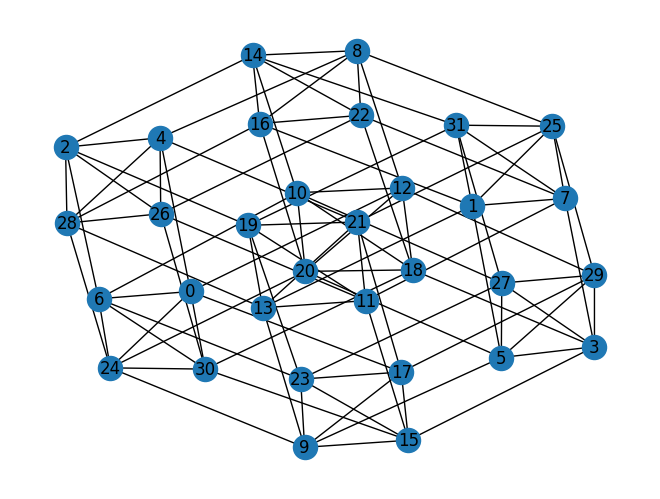

In [5]:
diagonal, D, A = decompose_laplacian_matrix(L)

G = nx.from_numpy_array(A)
nx.draw(G, with_labels=True)

The eigenspectrum of the Laplacian obtained by classical diagonalization:

In [6]:
display(Math(obtain_math_text_hermitian_spectrum(np.linalg.eigh(L))))

<IPython.core.display.Math object>

It can be seen that the eigenspectrum behaves like what we expect from a Laplacian's spectrum, but is highly degenerated. This phenomenon probably stems from high level of symmetry in the graph we generated.

I guess that the origin of this issue is the method of Laplacian generation explained in previous sections. I will not be surprised to find out that this observed symmetry renders the generated graphs easy to analyze even in an exponentially large regime. We should check that. However I hope that we will be able to generalize the proposed method to generate also non highly-degenerated Laplacians.

-------------

## Versions

In [7]:
from sys import version as python_version

print(f"{python_version=}")

python_version='3.12.3 (main, Jan 22 2026, 20:57:42) [GCC 13.3.0]'


In [8]:
pip freeze | grep -E "^(numpy|networkx|ipython|qiskit|jupyter|notebook|traitlets)=="

ipython==8.11.0
jupyter==1.1.1
networkx==3.5
notebook==6.4.8
numpy==1.26.4
qiskit==2.1.1
traitlets==5.9.0
Note: you may need to restart the kernel to use updated packages.
